In [301]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_venn
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

import math
import json

## **Reading the files**

In [236]:
# Extracting data from enquiry_data_train.json and storing it as a dataframe
with open('/content/drive/MyDrive/senior_ds_test/data/train/enquiry_data_train.json') as f_in:
    data = json.load(f_in)

res = []
for i in data:
    res.extend(i)

df_enquiry = pd.DataFrame(res)
df_enquiry.head()

,enquiry_type,enquiry_amt,enquiry_date,uid
0,Interbank credit,168839,2020-11-08,AAA08065248
1,Mobile operator loan,268392,2020-09-20,AAA08065248
2,Mobile operator loan,36082,2020-06-19,AAA08065248
3,Interbank credit,180467,2019-10-22,AAA08065248
4,Cash loan (non-earmarked),227459,2020-05-24,AAA08065248


In [237]:
# Extracting data from train_flag.csv and storing it as a dataframe
df_train = pd.read_csv('/content/drive/MyDrive/senior_ds_test/data/train/train_flag.csv')
df_train.head()

,uid,NAME_CONTRACT_TYPE,TARGET
0,XDA69787158,Cash loans,0
1,BSE47789733,Cash loans,0
2,NTJ92213825,Cash loans,0
3,TCQ47571695,Cash loans,0
4,WJZ68772744,Cash loans,0


In [238]:
# Extracting data from accounts_data_train.json and storing it as a dataframe
with open('/content/drive/MyDrive/senior_ds_test/data/train/accounts_data_train.json') as f_in:
    data = json.load(f_in)

res = []
for i in data:
    res.extend(i)

df_accounts = pd.DataFrame(res)
df_accounts.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550
2,Credit card,80996.445,0.0,2020-06-29,NaN,000000000000000000,AAA10545297
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888
4,Credit card,10480.500,0.0,2014-09-10,NaN,0000000000000000000000000000000000000000000000...,AAA20326915


## **Exploratory Data Analysis**

### **Data Understanding**

In [239]:
df_enquiry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1909926 entries, 0 to 1909925
Data columns (total 4 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   enquiry_type  object
 1   enquiry_amt   int64 
 2   enquiry_date  object
 3   uid           object
dtypes: int64(1), object(3)
memory usage: 58.3+ MB


In [240]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261383 entries, 0 to 261382
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   uid                 261383 non-null  object
 1   NAME_CONTRACT_TYPE  261383 non-null  object
 2   TARGET              261383 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.0+ MB


In [241]:
df_accounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245310 entries, 0 to 1245309
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   credit_type          1245310 non-null  object 
 1   loan_amount          1245307 non-null  float64
 2   amount_overdue       1245310 non-null  float64
 3   open_date            1245310 non-null  object 
 4   closed_date          782275 non-null   object 
 5   payment_hist_string  1245310 non-null  object 
 6   uid                  1245310 non-null  object 
dtypes: float64(2), object(5)
memory usage: 66.5+ MB


In [242]:
# Converting features to required types
df_enquiry["enquiry_date"] = pd.to_datetime(df_enquiry["enquiry_date"])

df_train["NAME_CONTRACT_TYPE"] = df_train["NAME_CONTRACT_TYPE"].astype('category')

df_accounts["credit_type"] = df_accounts["credit_type"].astype('category')
df_accounts["open_date"] = pd.to_datetime(df_accounts["open_date"])
df_accounts["closed_date"] = pd.to_datetime(df_accounts["closed_date"])
df_accounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245310 entries, 0 to 1245309
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   credit_type          1245310 non-null  category      
 1   loan_amount          1245307 non-null  float64       
 2   amount_overdue       1245310 non-null  float64       
 3   open_date            1245310 non-null  datetime64[ns]
 4   closed_date          782275 non-null   datetime64[ns]
 5   payment_hist_string  1245310 non-null  object        
 6   uid                  1245310 non-null  object        
dtypes: category(1), datetime64[ns](2), float64(2), object(2)
memory usage: 58.2+ MB


In [243]:
# Checking if open_date is greater than the closed date
df_accounts[df_accounts["open_date"] > df_accounts["closed_date"]]

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
65605,Another type of loan,NaN,0.0,2021-01-01,2020-10-21,,BJV01354901
91932,Consumer credit,153000.0,0.0,2019-07-08,2019-06-17,,BXW18347652
143642,Consumer credit,450000.0,0.0,2017-05-27,2017-04-14,,CZP89943956
147697,Consumer credit,360000.0,0.0,2013-06-05,2013-03-14,,DBX47652567
212896,Credit card,675000.0,0.0,2019-03-27,2015-11-29,,ELL49792531
380416,Consumer credit,711450.0,0.0,2018-03-17,2012-09-03,,HXU23242159
642848,Mortgage,2250000.0,0.0,2017-03-12,2013-10-18,,NLJ87108009
664086,Consumer credit,93564.0,0.0,2017-06-02,2016-12-02,,NWS78995671
752854,Credit card,225000.0,0.0,2014-08-06,1905-12-13,,PSI76661644
920889,Consumer credit,1350000.0,0.0,2018-07-29,2018-02-04,,TFK88667051


In [244]:
# Since we cannot extract any meaning out of the data where open date is greater than the closed date, we drop them.
# We could decide to keep this data if has some business meaning, but we drop them for now.
df_accounts.drop(df_accounts[df_accounts["open_date"] > df_accounts["closed_date"]].index, inplace=True)
df_accounts[df_accounts["open_date"] > df_accounts["closed_date"]]

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid


### **Handling nulls and duplicates**

In [245]:
# Checking for nulls in the enquiry data
df_enquiry.isna().sum()

enquiry_type    0
enquiry_amt     0
enquiry_date    0
uid             0
dtype: int64

There are 1909926 rows and 4 columns in the enquiry data and column has nulls.

In [246]:
# Checking for duplicates in the enquiry data
df_enquiry[df_enquiry.duplicated()]

,enquiry_type,enquiry_amt,enquiry_date,uid
57165,Loan for the purchase of equipment,10000,2019-09-23,AUI06389548
300577,Real estate loan,35000,2020-12-19,EDB71045421
567997,Microloan,54000,2020-12-03,HSM96086685
662468,Loan for the purchase of equipment,87000,2020-09-19,IZU63959642
1037451,Car loan,54000,2020-03-23,OCH98359013
1639260,Cash loans,135000,2020-10-26,WHR93617705
1751503,Cash loans,100000,2020-06-30,XWD32334001
1818626,Microloan,153000,2020-11-16,YUC71183169
1844464,Revolving loans,108000,2020-12-05,ZDI71891543


In [247]:
# Deleting the duplicated data
df_enquiry.drop_duplicates(inplace = True)
df_enquiry.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1909917 entries, 0 to 1909925
Data columns (total 4 columns):
 #   Column        Dtype         
---  ------        -----         
 0   enquiry_type  object        
 1   enquiry_amt   int64         
 2   enquiry_date  datetime64[ns]
 3   uid           object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 72.9+ MB


There are 261383 rows and 3 columns in the enquiry data and no column has nulls.

In [248]:
# Checking for duplicates in the train data
df_train[df_train.duplicated()]

,uid,NAME_CONTRACT_TYPE,TARGET


No duplicate rows found in train_flag.csv

There are 1245310 rows and 7 columns in the enquiry data and 2 columns have nulls.

In [249]:
# Checking for duplicates in the accounts data
df_accounts[df_accounts.duplicated()]

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
139,Credit card,0.0,0.0,2019-08-20,NaT,000000000000000000000000000000000000000000000000,AAD16503034
194,Car loan,1449657.0,0.0,2014-08-17,2019-05-01,0000000000000000000000000000000000000000000000...,AAD61169674
309,Credit card,0.0,0.0,2018-01-12,NaT,0000000000000000000000000000000000000000000000...,AAE71583603
318,Credit card,135000.0,0.0,2019-03-24,NaT,0000000000000000000000000000000000000000000000...,AAE71583603
638,Consumer credit,225000.0,0.0,2013-10-08,2016-10-18,0000000000000000000000000000000000000000000000...,AAI20535173
...,...,...,...,...,...,...,...
1244874,Credit card,0.0,0.0,2019-10-16,NaT,000000000000000000000000000000000000000000,ZZT80609715
1244875,Credit card,0.0,0.0,2019-10-16,NaT,000000000000000000000000000000000000000000,ZZT80609715
1244921,Car loan,1732455.0,0.0,2016-06-23,NaT,0000000000000000000000000000000000000000000000...,ZZU59750674
1245219,Consumer credit,157500.0,0.0,2018-05-16,NaT,0000000000000000000000000000000000000000000000...,ZZY61268290


In [250]:
# Deleting the duplicated data
df_accounts.drop_duplicates(inplace = True)
df_accounts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1238886 entries, 0 to 1245309
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   credit_type          1238886 non-null  category      
 1   loan_amount          1238884 non-null  float64       
 2   amount_overdue       1238886 non-null  float64       
 3   open_date            1238886 non-null  datetime64[ns]
 4   closed_date          779790 non-null   datetime64[ns]
 5   payment_hist_string  1238886 non-null  object        
 6   uid                  1238886 non-null  object        
dtypes: category(1), datetime64[ns](2), float64(2), object(2)
memory usage: 67.3+ MB


In [251]:
# checking the records where loan_amount is null
df_accounts[df_accounts["loan_amount"].isna()]

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
149202,Another type of loan,NaN,0.0,2021-01-01,NaT,,DCX71532515
613183,Another type of loan,NaN,0.0,2021-01-01,NaT,,MVG95017452


We could have tried to fill the nulls of the loan_amount by using the average of enquiry_amt grouped by enquiry_type from df_enquiry (as it has same values as credit_type feature of the accounts dataset). But, since there is no information present in the other columns of these rows as well, and since the records with loan_amount null are very less (0.00024%, 3 out of 1238899), we can safely drop them.

In [252]:
# Dropping the null data of the loan amount
df_accounts.dropna(subset=['loan_amount'], inplace=True)
df_accounts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1238884 entries, 0 to 1245309
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   credit_type          1238884 non-null  category      
 1   loan_amount          1238884 non-null  float64       
 2   amount_overdue       1238884 non-null  float64       
 3   open_date            1238884 non-null  datetime64[ns]
 4   closed_date          779790 non-null   datetime64[ns]
 5   payment_hist_string  1238884 non-null  object        
 6   uid                  1238884 non-null  object        
dtypes: category(1), datetime64[ns](2), float64(2), object(2)
memory usage: 67.3+ MB


In [253]:
# The closed date null would mean the loan is still running. But, in the cases where loan_overdue is 0, or the loan_amount is itself 0,
# we can put a closed date of today, for better analysis.

df_accounts.loc[(df_accounts["closed_date"].isnull()) & (df_accounts["amount_overdue"] == 0), "closed_date"] = pd.to_datetime('today').replace(hour=0, minute=0, second=0, microsecond=0)
df_accounts.loc[(df_accounts["closed_date"].isnull()) & (df_accounts["amount_overdue"] == 0) & (df_accounts["loan_amount"] == 0), "closed_date"] = pd.to_datetime('today').replace(hour=0, minute=0, second=0, microsecond=0)

df_accounts.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550
2,Credit card,80996.445,0.0,2020-06-29,2023-12-18,000000000000000000,AAA10545297
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888
4,Credit card,10480.500,0.0,2014-09-10,2023-12-18,0000000000000000000000000000000000000000000000...,AAA20326915


## **Visual Analysis**

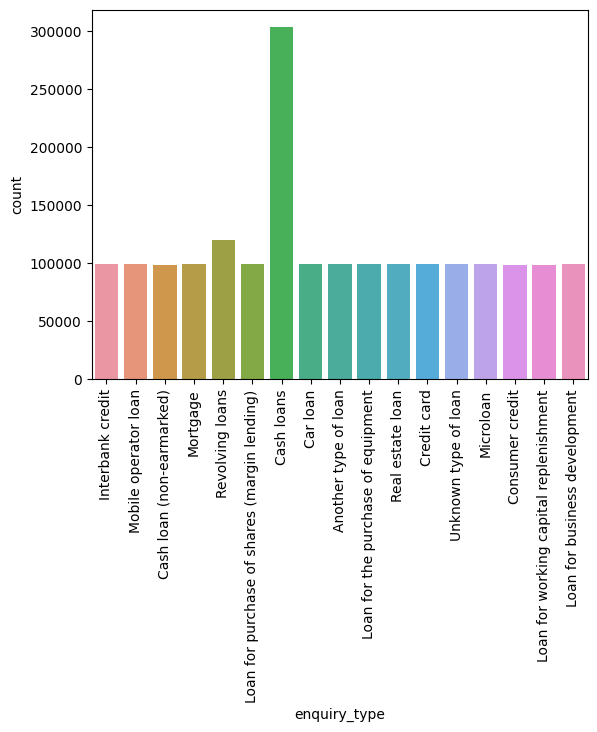

In [254]:
# Checking the number of enquiry types
sns.countplot(df_enquiry, x='enquiry_type').tick_params(axis='x', rotation=90)

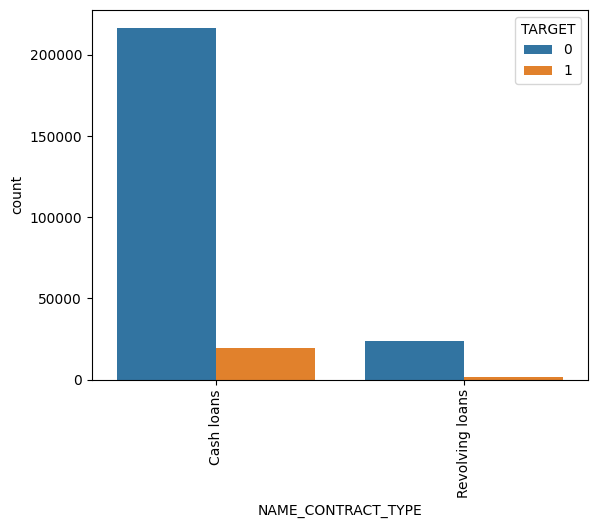

In [255]:
# Checking the number of contract types in the train data
sns.countplot(df_train, x='NAME_CONTRACT_TYPE', hue = 'TARGET').tick_params(axis='x', rotation=90)

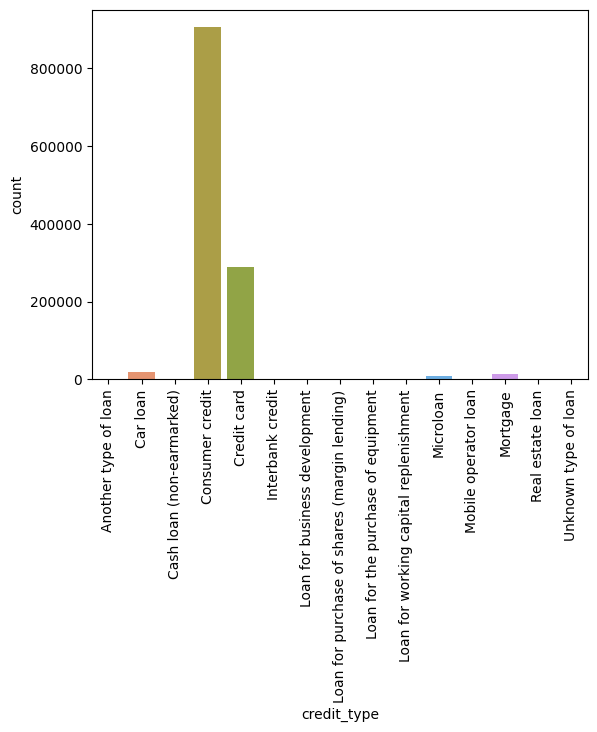

In [256]:
# Checking the number of credit types
sns.countplot(df_accounts, x='credit_type').tick_params(axis='x', rotation=90)

## **Preparing the dataset**

### **Feature Creation**

In [257]:
# Finding the number of times a payment was delayed by the customer by referring to the 3-string blocks of payment_hist_string
# in the dataset df_accounts
def count_non_zero_triplets(string):
    count = 0
    for i in range(0, len(string), 3):
        triplet = string[i:i+3]
        if int(triplet) != 0:
            count += 1
    return count

df_accounts["no_of_times_overdue"] = df_accounts["payment_hist_string"].apply(lambda x: count_non_zero_triplets(x))
df_accounts.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,no_of_times_overdue
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550,1
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550,2
2,Credit card,80996.445,0.0,2020-06-29,2023-12-18,000000000000000000,AAA10545297,0
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888,0
4,Credit card,10480.500,0.0,2014-09-10,2023-12-18,0000000000000000000000000000000000000000000000...,AAA20326915,31


In [258]:
# Finding the number of months it took for the customer to repay the loan. In case of running loans, today's date is used.
df_accounts["months_passed"] = (df_accounts["closed_date"] - df_accounts["open_date"])/np.timedelta64(1, 'M')
df_accounts.loc[(df_accounts["months_passed"].isnull()), "months_passed"] = (pd.to_datetime('today') - df_accounts["open_date"])/np.timedelta64(1, 'M')
df_accounts["months_passed"] = df_accounts["months_passed"].astype(int)

# Number of times a customer enquired about a loan
df_enquiry["no_of_enquiries"] = df_enquiry.groupby("uid").uid.transform('count')

# Number of loans taken by a customer
df_accounts["no_of_loans"] = df_accounts.groupby("uid").uid.transform('count')

# Maximum times a loan was paid late by a customer
df_accounts["max_late_payment"] = df_accounts.groupby(["uid"])["no_of_times_overdue"].transform('max')

### **Preparing Input Dataset**

In [259]:
# Removing the multiple enquiries made by a single customer, keeping only the last one made
df_enquiry.sort_values(by = ["enquiry_date"], inplace = True)
df_enquiry.drop_duplicates(subset = ["uid", "enquiry_type"], keep = "last", inplace = True)
df_enquiry.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1332473 entries, 687427 to 1524689
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   enquiry_type     1332473 non-null  object        
 1   enquiry_amt      1332473 non-null  int64         
 2   enquiry_date     1332473 non-null  datetime64[ns]
 3   uid              1332473 non-null  object        
 4   no_of_enquiries  1332473 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 61.0+ MB


In [260]:
# Keeping the average of all the numeric features in the accounts data for each customer
a = df_accounts.groupby('uid').agg({'loan_amount' : 'mean',  'no_of_times_overdue' : 'mean', 'months_passed' : 'mean',
                         'no_of_loans':'mean', 'max_late_payment' : 'mean', 'amount_overdue' : 'mean', 'open_date' : 'max',
                         'closed_date' : 'max'}).reset_index()
a.head()

,uid,loan_amount,no_of_times_overdue,months_passed,no_of_loans,max_late_payment,amount_overdue,open_date,closed_date
0,AAA09044550,138622.500,1.500,16.50,2.0,2.0,0.0,2018-09-22,2020-02-22
1,AAA10545297,80996.445,0.000,41.00,1.0,0.0,0.0,2020-06-29,2023-12-18
2,AAA14112888,43771.500,0.000,3.00,1.0,0.0,0.0,2020-06-09,2020-09-09
3,AAA20326915,73949.625,3.875,31.75,8.0,31.0,0.0,2020-06-28,2023-12-18
4,AAA31604840,318392.100,0.000,37.00,5.0,0.0,0.0,2020-10-10,2023-12-18


In [261]:
# Merging all the three datasets
df_temp = pd.merge(df_enquiry, a, on = "uid", how = 'right')
df = pd.merge(df_train, df_temp, left_on = ["uid", "NAME_CONTRACT_TYPE"], right_on = ["uid", "enquiry_type"], how = 'left')
df.head()

,uid,NAME_CONTRACT_TYPE,TARGET,enquiry_type,enquiry_amt,enquiry_date,no_of_enquiries,loan_amount,no_of_times_overdue,months_passed,no_of_loans,max_late_payment,amount_overdue,open_date,closed_date
0,XDA69787158,Cash loans,0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1,BSE47789733,Cash loans,0,Cash loans,150000.0,2020-11-13,3.0,110155.5,0.0,0.0,1.0,0.0,0.0,2018-09-26,2018-10-26
2,NTJ92213825,Cash loans,0,Cash loans,8000.0,2020-02-05,4.0,103783.5,0.0,9.0,1.0,0.0,0.0,2014-01-19,2014-11-19
3,TCQ47571695,Cash loans,0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
4,WJZ68772744,Cash loans,0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT


In [262]:
# New feature creation: on the basis of difference in dates
df["enq_open_date_diff"] = (df["enquiry_date"] - df["open_date"])/np.timedelta64(1, 'M')
df.loc[(df["enq_open_date_diff"].isnull()), "enq_open_date_diff"] = (df["enquiry_date"] - pd.to_datetime('today'))/np.timedelta64(1, 'M')

df["enq_closed_date_diff"] = (df["enquiry_date"] - df["closed_date"])/np.timedelta64(1, 'M')
df.loc[(df["enq_closed_date_diff"].isnull()), "enq_closed_date_diff"] = (df["enquiry_date"] - pd.to_datetime('today'))/np.timedelta64(1, 'M')

In [263]:
# Dropping the not needed columns
df.drop(["enquiry_date"], axis=1, inplace = True)
df.drop(["open_date"], axis=1, inplace = True)
df.drop(["closed_date"], axis=1, inplace = True)

# Filling all the unavailable values with null. If the customer hasn't made any enquiry or if it is the first loan of the customer,
# the corresponding features of the dataset are made 0.
df["enquiry_type"].fillna("No Enquiries")
df.fillna(0, inplace=True)
df.isna().sum()

uid                     0
NAME_CONTRACT_TYPE      0
TARGET                  0
enquiry_type            0
enquiry_amt             0
no_of_enquiries         0
loan_amount             0
no_of_times_overdue     0
months_passed           0
no_of_loans             0
max_late_payment        0
amount_overdue          0
enq_open_date_diff      0
enq_closed_date_diff    0
dtype: int64

In [264]:
df.shape

(261383, 14)

In [265]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261383 entries, 0 to 261382
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   uid                   261383 non-null  object 
 1   NAME_CONTRACT_TYPE    261383 non-null  object 
 2   TARGET                261383 non-null  int64  
 3   enquiry_type          261383 non-null  object 
 4   enquiry_amt           261383 non-null  float64
 5   no_of_enquiries       261383 non-null  float64
 6   loan_amount           261383 non-null  float64
 7   no_of_times_overdue   261383 non-null  float64
 8   months_passed         261383 non-null  float64
 9   no_of_loans           261383 non-null  float64
 10  max_late_payment      261383 non-null  float64
 11  amount_overdue        261383 non-null  float64
 12  enq_open_date_diff    261383 non-null  float64
 13  enq_closed_date_diff  261383 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 38

## **Univariate and Bivariate Analysis**

<Axes: xlabel='NAME_CONTRACT_TYPE', ylabel='count'>

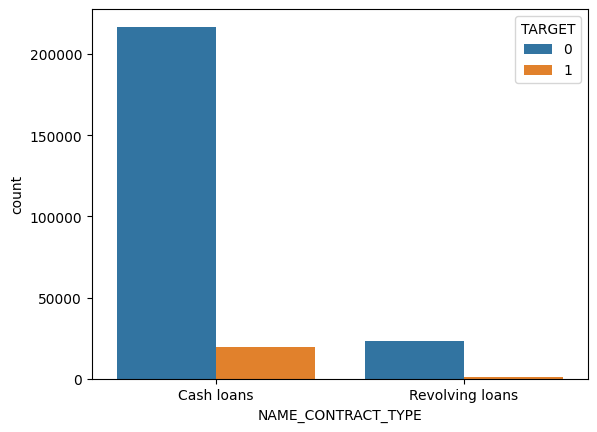

In [266]:
# Checking the number of contract types in the final dataset
sns.countplot(df, x='NAME_CONTRACT_TYPE', hue = 'TARGET')

<Axes: xlabel='enquiry_amt', ylabel='Count'>

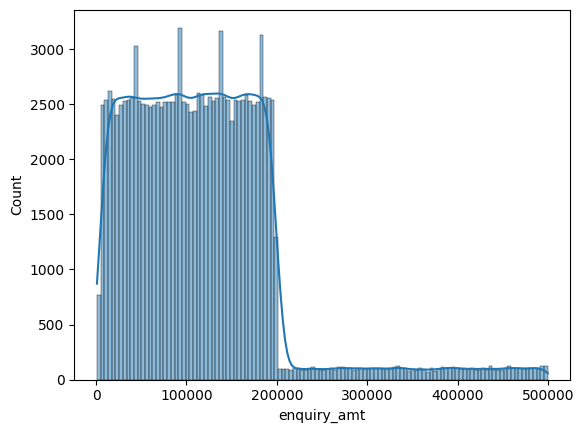

In [273]:
# Plotting the amounts for which enquiries were made by the customer
sns.histplot(data = df[df["enquiry_amt"] != 0], x = "enquiry_amt", kde = True)

<Axes: xlabel='loan_amount', ylabel='Density'>

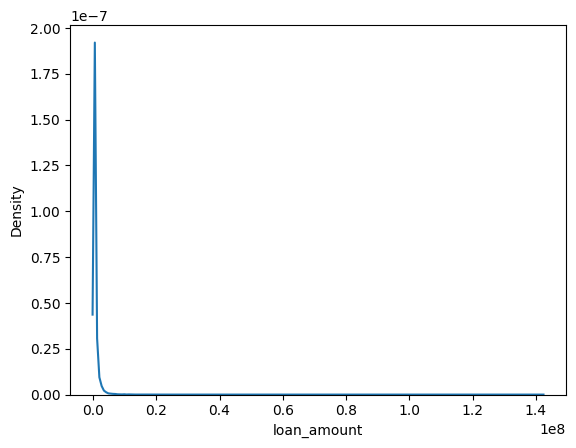

In [279]:
# Plotting the loan amounts already incurred by the customer
sns.kdeplot(data = df, x = "loan_amount")

<Axes: xlabel='amount_overdue', ylabel='Density'>

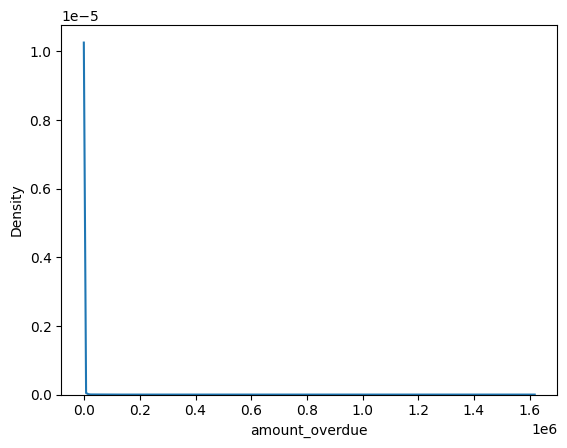

In [278]:
# Plotting the amounts overdue for customers
sns.kdeplot(data = df, x = "amount_overdue")

<Axes: xlabel='months_passed', ylabel='Count'>

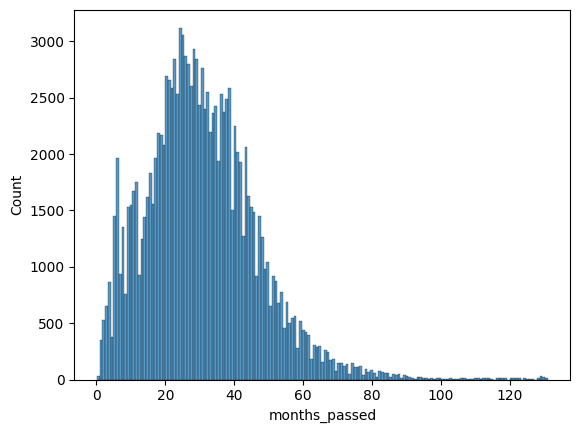

In [277]:
# Plotting the months a loan has been taken by the customer
sns.histplot(data = df[df["months_passed"] != 0], x = "months_passed")

<Axes: xlabel='enq_open_date_diff', ylabel='Count'>

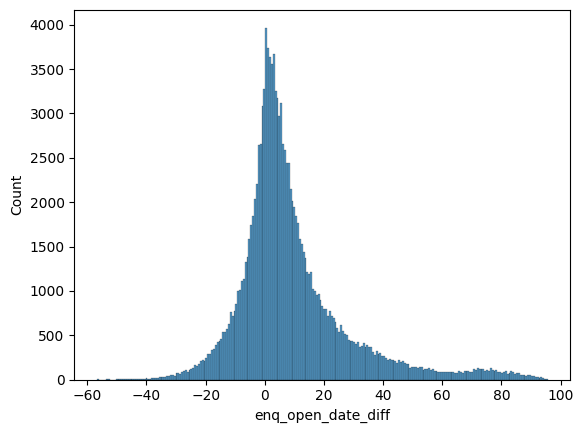

In [281]:
sns.histplot(data = df[df["enq_open_date_diff"] != 0], x = "enq_open_date_diff")

<Axes: xlabel='enq_closed_date_diff', ylabel='Count'>

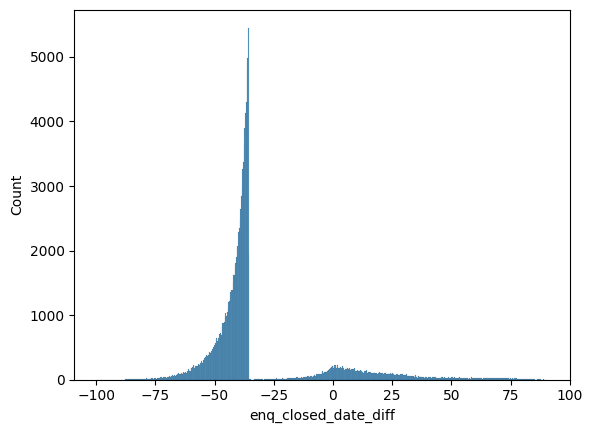

In [283]:
sns.histplot(data = df[df["enq_closed_date_diff"] != 0], x = "enq_closed_date_diff")

<Axes: ylabel='enquiry_amt'>

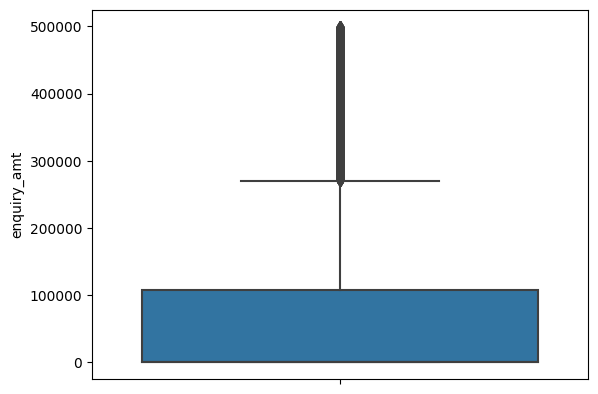

In [285]:
sns.boxplot(data = df, y = 'enquiry_amt')

In [286]:
df['TARGET'].value_counts()

0    240326
1     21057
Name: TARGET, dtype: int64

<Axes: ylabel='TARGET'>

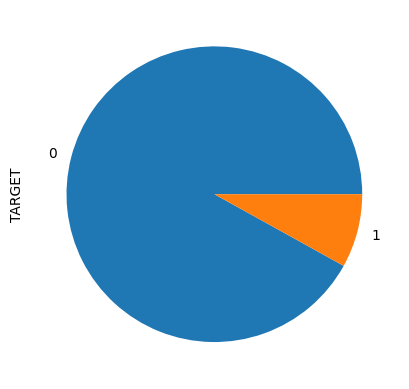

In [287]:
df['TARGET'].value_counts().plot(kind="pie")

In [288]:
# Outlier detection in the numerical data
df_temp = df[["enquiry_amt", "loan_amount", "amount_overdue", "no_of_enquiries", "no_of_times_overdue", "months_passed", "no_of_loans", "max_late_payment", "enq_open_date_diff", "enq_closed_date_diff", "TARGET"]]
Q = df_temp.quantile(0.01)
Q_dash = df_temp.quantile(0.99)
Range = Q_dash - Q
upper = Q_dash + 1.5 * Range
lower = Q - 1.5 * Range

((df_temp < lower) | (df_temp > upper)).sum()

enquiry_amt                0
loan_amount              436
amount_overdue          1653
no_of_enquiries            0
no_of_times_overdue      523
months_passed              0
no_of_loans               16
max_late_payment         411
enq_open_date_diff         0
enq_closed_date_diff       0
TARGET                     0
dtype: int64

## **Insights drawn from the data**



1.   The target feature TARGET is not balanced (664868 0s and 56270 1s).
2.   All the features enquiry_amt, loan_amount, amount_overdue, no_of_times_overdue, months_passed are right skewed.
3.   We have significant number of outliers in the data in some of the numeric columns required for model building.



## **Feature Scaling**

In [289]:
# Using target encoding for the NAME_CONTRACT_TYPE feature
df["Contract_type_encoded"] = df[["NAME_CONTRACT_TYPE", "TARGET"]].groupby("NAME_CONTRACT_TYPE")["TARGET"].transform("mean")

In [290]:
# Extracting all the required feature for model building
df_model = df[["enquiry_amt", "no_of_enquiries", "loan_amount", "amount_overdue", "no_of_times_overdue", "months_passed", "no_of_loans", "max_late_payment", "Contract_type_encoded", "enq_open_date_diff", "enq_closed_date_diff", "TARGET"]]

In [291]:
# z-score standardization of all the numeric data
X = df_model.copy()
X["enquiry_amt"] = (df_model["enquiry_amt"] - df_model["enquiry_amt"].mean()) / df_model["enquiry_amt"].std()
X["no_of_enquiries"] = (df_model["no_of_enquiries"] - df_model["no_of_enquiries"].mean()) / df_model["no_of_enquiries"].std()
X["loan_amount"] = (df_model["loan_amount"] - df_model["loan_amount"].mean()) / df_model["loan_amount"].std()
X["amount_overdue"] = (df_model["amount_overdue"] - df_model["amount_overdue"].mean()) / df_model["amount_overdue"].std()
X["no_of_times_overdue"] = (df_model["no_of_times_overdue"] - df_model["no_of_times_overdue"].mean()) / df_model["no_of_times_overdue"].std()
X["months_passed"] = (df_model["months_passed"] - df_model["months_passed"].mean()) / df_model["months_passed"].std()
X["no_of_loans"] = (df_model["no_of_loans"] - df_model["no_of_loans"].mean()) / df_model["no_of_loans"].std()
X["max_late_payment"] = (df_model["max_late_payment"] - df_model["max_late_payment"].mean()) / df_model["max_late_payment"].std()
X["enq_open_date_diff"] = (df_model["enq_open_date_diff"] - df_model["enq_open_date_diff"].mean()) / df_model["enq_open_date_diff"].std()
X["enq_closed_date_diff"] = (df_model["enq_closed_date_diff"] - df_model["enq_closed_date_diff"].mean()) / df_model["enq_closed_date_diff"].std()

# Adding a feature of 1s to complement the bias weight of the model (theta0)
x0 = np.ones((X.shape[0], 1))
X.insert(loc = 0, column="x0", value=x0)
X.head(10)

,x0,enquiry_amt,no_of_enquiries,loan_amount,amount_overdue,no_of_times_overdue,months_passed,no_of_loans,max_late_payment,Contract_type_encoded,enq_open_date_diff,enq_closed_date_diff,TARGET
0,1.0,-0.705672,-0.694431,-0.299337,-0.007318,-0.205685,-0.799557,-0.666127,-0.263734,0.083294,-0.323205,0.666609,0
1,1.0,1.124134,-0.288114,-0.123834,-0.007318,-0.205685,-0.799557,-0.424683,-0.263734,0.083294,1.468971,1.696271,0
2,1.0,-0.608082,-0.152675,-0.133986,-0.007318,-0.205685,-0.329755,-0.424683,-0.263734,0.083294,4.756545,3.284068,0
3,1.0,-0.705672,-0.694431,-0.299337,-0.007318,-0.205685,-0.799557,-0.666127,-0.263734,0.083294,-0.323205,0.666609,0
4,1.0,-0.705672,-0.694431,-0.299337,-0.007318,-0.205685,-0.799557,-0.666127,-0.263734,0.083294,-0.323205,0.666609,0
5,1.0,0.148238,1.743471,0.102005,-0.007318,-0.205685,0.766450,0.058204,-0.263734,0.083294,1.397652,-1.181010,0
6,1.0,-0.705672,-0.694431,-0.299337,-0.007318,-0.205685,-0.799557,-0.666127,-0.263734,0.083294,-0.323205,0.666609,0
7,1.0,-0.705672,-0.694431,-0.299337,-0.007318,-0.205685,-0.799557,-0.666127,-0.263734,0.083294,-0.323205,0.666609,1
8,1.0,-0.705672,-0.694431,-0.299337,-0.007318,-0.205685,-0.799557,-0.666127,-0.263734,0.054548,-0.323205,0.666609,0
9,1.0,0.489801,-0.152675,1.525371,-0.007318,-0.205685,-0.486355,-0.424683,-0.263734,0.083294,-0.295598,0.408162,0


In [292]:
# Capping outliers: not used for logistic in pandas

for i in X.columns:
    X.loc[(X[i] >= 3), i] = 3
    X.loc[(X[i] <= -3), i] = -3
    # X = X[(X[i] <= 3) & (X[i] >= -3)] # removing the outliers

X.shape

(261383, 13)

In [293]:
# Checking the skew before z-score standardization
df_model.skew()

enquiry_amt                1.884031
no_of_enquiries            1.748385
loan_amount               60.622680
amount_overdue           227.341111
no_of_times_overdue       16.577360
months_passed              1.155138
no_of_loans                2.183285
max_late_payment           8.046970
Contract_type_encoded     -2.760401
enq_open_date_diff         2.771484
enq_closed_date_diff       0.036569
TARGET                     3.082344
dtype: float64

In [294]:
# Checking the skew of the final data: X
X.skew()

x0                        0.000000
enquiry_amt               1.252837
no_of_enquiries           1.438602
loan_amount               3.474705
amount_overdue           52.095180
no_of_times_overdue       4.207848
months_passed             0.955721
no_of_loans               1.556448
max_late_payment          3.567334
Contract_type_encoded    -2.760401
enq_open_date_diff        1.817254
enq_closed_date_diff     -0.075885
TARGET                    3.082344
dtype: float64

The skewness has decreased a little after z-score normalization. The data is still skewed though.

In [ ]:
# Lognormal trasformation: doesn't work- many data values are 0, set the value to Nan

# X_temp = X.copy()
# X[["loan_amount", "amount_overdue", "no_of_times_overdue", "max_late_payment"]] = np.sqrt(X[["loan_amount", "amount_overdue", "no_of_times_overdue", "max_late_payment"]])
# X.skew()

In [295]:
# Extracting Target from X and storing it in Y (target variable)
Y = X["TARGET"]
X.drop(["TARGET"], axis=1, inplace = True)
X

,x0,enquiry_amt,no_of_enquiries,loan_amount,amount_overdue,no_of_times_overdue,months_passed,no_of_loans,max_late_payment,Contract_type_encoded,enq_open_date_diff,enq_closed_date_diff
0,1.0,-0.705672,-0.694431,-0.299337,-0.007318,-0.205685,-0.799557,-0.666127,-0.263734,0.083294,-0.323205,0.666609
1,1.0,1.124134,-0.288114,-0.123834,-0.007318,-0.205685,-0.799557,-0.424683,-0.263734,0.083294,1.468971,1.696271
2,1.0,-0.608082,-0.152675,-0.133986,-0.007318,-0.205685,-0.329755,-0.424683,-0.263734,0.083294,3.000000,3.000000
3,1.0,-0.705672,-0.694431,-0.299337,-0.007318,-0.205685,-0.799557,-0.666127,-0.263734,0.083294,-0.323205,0.666609
4,1.0,-0.705672,-0.694431,-0.299337,-0.007318,-0.205685,-0.799557,-0.666127,-0.263734,0.083294,-0.323205,0.666609
...,...,...,...,...,...,...,...,...,...,...,...,...
261378,1.0,-0.705672,-0.694431,-0.299337,-0.007318,-0.205685,-0.799557,-0.666127,-0.263734,0.083294,-0.323205,0.666609
261379,1.0,0.441006,1.337154,0.355945,-0.007318,-0.205685,0.335798,1.265423,-0.263734,0.083294,-0.008021,-1.282739
261380,1.0,0.136039,3.000000,1.509125,-0.007318,0.235268,0.352863,2.472642,1.299146,0.083294,0.295660,-0.830457
261381,1.0,1.810079,-0.558992,3.000000,-0.007318,-0.205685,2.254156,0.299648,-0.263734,0.054548,0.376181,-0.848329


## **Logistic Regression using pandas**

In [296]:
# Splitting the training data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 10)

In [297]:
# Logistic Regression
# The function to consider is h(z) = 1 / (1 + np.exp(-z), where z = theta.transpose * x
# The loss function is : loss = -y * np.log(h) - (1 - y) * np.log(1 - h)

def sigmoid(X, theta):
    z = np.dot(X, theta)
    return 1 / (1 + np.exp(-z))

def logistic_regression(X, y, theta):
    iters = 300
    alpha = 0.1 # changed from 0.01 to 0.1 as the loss function descended rapidly
    loss = []
    m = X.shape[0] # no of training examples
    # n = X.shape[1] # no of features
    for i in range(iters):
        y_pred = sigmoid(X, theta)
        theta = theta - (alpha / m) * (np.dot(X.T, (y_pred - y)))
        loss_value = ((-1 * y * np.log(y_pred)) - ((1 - y) * np.log(1 - y_pred))).mean()
        loss.append(loss_value)
    Y_combined = pd.DataFrame({'y_pred': y_pred, 'y': y}, columns=['y_pred', 'y'])
    Y_combined["Y_hat"] = Y_combined["y_pred"].apply(lambda x : 0 if x < 0.5 else 1)
    return theta, Y_combined, loss

# Initializing weights
theta = np.zeros(X_train.shape[1])

# Calling the logistic_regression function
theta, Y_combined, loss = logistic_regression(X_train, y_train, theta)


In [298]:
# Predicting the test data using the model created in the previous block
def predict(X, y, theta):
    y_pred = np.dot(X, theta)
    # Y_combined_test = pd.DataFrame(np.around(y_pred, decimals=6), columns=["Y_hat_cont"]).join(y)
    Y_combined_test = pd.DataFrame({'y_pred': y_pred, 'y': y}, columns=['y_pred', 'y'])
    Y_combined_test["Y_hat"] = Y_combined_test["y_pred"].apply(lambda x : 0 if x < 0.5 else 1)
    return Y_combined_test

In [303]:
Y_combined_test = predict(X_test, y_test, theta)

print("Accuracy: ", metrics.accuracy_score(Y_combined_test["y"], Y_combined_test["Y_hat"]))
print("Precision: ", metrics.precision_score(Y_combined_test["y"], Y_combined_test["Y_hat"]))
print("Recall: ", metrics.recall_score(Y_combined_test["y"], Y_combined_test["Y_hat"]))
print("roc_auc_score: ", roc_auc_score(Y_combined_test["y"], Y_combined_test["Y_hat"]))

Accuracy:  0.9192884014538035
Precision:  0.0
Recall:  0.0
roc_auc_score:  0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

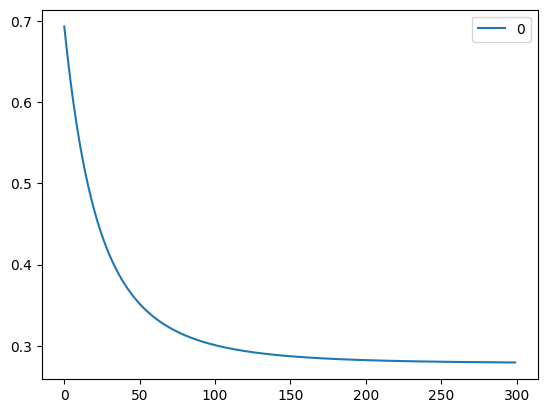

In [304]:
# Plotting values of the loss function after every iteration
pd.DataFrame(loss).plot(kind = 'line')

### **Insights from the model**



1.   The value of alpha was decreased to 0.1 from 0.01 since the loss function went sharply down (in the graph).
2.   The roc_auc_score by feeding in the plain data (without handling outliers and without chaning the distribution is 0.49, which is as good as predicting by guess. We need to fine tune the model.
3. Both precision and recall are 0, but the accuracy is high, that could mean the model predicts 0 most of the times and that becomes correct due to imbalanced number of 0s and 1s.



## **Logistic regression using libraries**

In [305]:
# Importing the libraries
from sklearn.linear_model import LogisticRegression

In [306]:
# Splitting X into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

In [307]:
# Training the model
log_reg = LogisticRegression(class_weight = 'balanced', C = 5, solver = 'newton-cholesky')
log_reg.fit(X_train, y_train)

# Predicting the test data
y_pred = log_reg.predict(X_test)

# Plotting the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix

array([[24988, 47191],
       [ 1522,  4714]])

In [308]:
# Displaying the metrics
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("Recall: ", metrics.recall_score(y_test, y_pred))
print("roc_auc_score: ", roc_auc_score(y_test, y_pred))

Accuracy:  0.37877957023528663
Precision:  0.0908197668818033
Recall:  0.7559332905708788
roc_auc_score:  0.5510640835985221


In [309]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.35      0.51     72179
           1       0.09      0.76      0.16      6236

    accuracy                           0.38     78415
   macro avg       0.52      0.55      0.33     78415
weighted avg       0.87      0.38      0.48     78415



### **Insights from the model**



1.   A simple implementation of logistic regression (without any tuning parameters) gives the results as follows:

    *   **Accuracy**:  0.9220044536557519
    *   **Precision**:  0.6666666666666666
    *   **Recall**:  0.00039554354275166457
    *   **roc_auc_score**:  0.5001894048775014
    *   The accuracy is (falsely) high, but the precision has improved. In our case, the false negatives would have a higher impact than the false positives (since an actual good loan not given is OK, but an actual bad loan considered a good one could be loss-making). Thus, we need recall to be high.

2.   After changing the class_weight, C and solver parameters in the function, we get better values of recall and roc_auc_score. These final values are shown in the above blocks.

## **SVM using libraries**

In [63]:
# Importing the libraries
from sklearn import svm

In [64]:
# Splitting X into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4)

In [ ]:
# Training the model
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predicting the test data
y_pred = svm_model.predict(X_test)

In [ ]:
# Displaying the metrics
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("Recall: ", metrics.recall_score(y_test, y_pred))
print("roc_auc_score: ", roc_auc_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

### **Insights from the model**

The model took too much time to be trained. Thus, no conclusions here.

## **Random Forest using libraries**

In [310]:
# Importing the libraries
from sklearn.ensemble import RandomForestClassifier

In [311]:
# Splitting X into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

In [314]:
# Training the model
rf = RandomForestClassifier(class_weight = 'balanced')
rf.fit(X_train, y_train)

# Predicting the test data
y_pred = rf.predict(X_test)

In [315]:
# Displaying the metrics
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("Recall: ", metrics.recall_score(y_test, y_pred))
print("roc_auc_score: ", roc_auc_score(y_test, y_pred), '\n')

print(classification_report(y_test, y_pred))

Accuracy:  0.5459032072945227
Precision:  0.08785798683396162
Recall:  0.4950856055802156
roc_auc_score:  0.5227171963996048 

              precision    recall  f1-score   support

           0       0.93      0.55      0.69     72107
           1       0.09      0.50      0.15      6308

    accuracy                           0.55     78415
   macro avg       0.51      0.52      0.42     78415
weighted avg       0.86      0.55      0.65     78415



### **Insights from the model**



1.   A simple implementation of Random Forest (without any tuning parameters) gives the results as follows:

    *   **Accuracy**:  0.9242949209623811
    *   **Precision**:  0.967020023557126
    *   **Recall**:  0.045694885067067405
    *   **roc_auc_score**:  0.5227804206508889

2.   After changing the class_weight parameter in the function, we get better values of recall and roc_auc_score. These final values are shown in the above blocks.

## **Working with the Test Dataset**

### **Preparing Test Data**

In [316]:
# Extracting data from enquiry_data_test.json and storing it as a dataframe
with open('/content/drive/MyDrive/senior_ds_test/data/test/enquiry_data_test.json') as f_in:
    data = json.load(f_in)

res = []
for i in data:
    res.extend(i)

df_enquiry_test = pd.DataFrame(res)
df_enquiry_test.head()

,enquiry_type,enquiry_amt,enquiry_date,uid
0,Car loan,143000,2020-12-13,AAA02107680
1,Real estate loan,174000,2020-12-01,AAA14437029
2,Loan for working capital replenishment,65000,2019-07-01,AAA14437029
3,Loan for working capital replenishment,118000,2020-08-05,AAA14437029
4,Car loan,12000,2020-02-28,AAA14437029


In [317]:
# Extracting data from test_flag.csv and storing it as a dataframe
df_test = pd.read_csv('/content/drive/MyDrive/senior_ds_test/data/test/test_flag.csv')
df_test.head()

,uid,NAME_CONTRACT_TYPE
0,CMO22835242,Cash loans
1,MRJ34316727,Cash loans
2,UAV00534378,Cash loans
3,IPQ08190402,Cash loans
4,NQN84331006,Cash loans


In [318]:
df_test.shape

(46127, 2)

In [319]:
# Extracting data from accounts_data_test.json and storing it as a dataframe
with open('/content/drive/MyDrive/senior_ds_test/data/test/accounts_data_test.json') as f_in:
    data = json.load(f_in)

res = []
for i in data:
    res.extend(i)

df_accounts_test = pd.DataFrame(res)
df_accounts_test.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,31630.50,0.0,2014-03-30,2014-11-29,000000000000000000000000,AAA14437029
1,Consumer credit,14613.39,0.0,2014-06-01,2014-11-03,000000000000000,AAA14437029
2,Credit card,54000.00,0.0,2015-12-13,2019-09-21,0000000000000000000000000000000000000000000000...,AAA14437029
3,Consumer credit,27076.50,0.0,2015-11-11,2016-11-24,000000000000000000000000000000000000,AAA14437029
4,Credit card,225000.00,0.0,2017-07-15,2019-11-14,0000000000000000000000000000000000000000000000...,AAA14437029


In [320]:
# Converting features to required types
df_enquiry_test["enquiry_date"] = pd.to_datetime(df_enquiry_test["enquiry_date"])

df_test["NAME_CONTRACT_TYPE"] = df_test["NAME_CONTRACT_TYPE"].astype('category')

df_accounts_test["open_date"] = pd.to_datetime(df_accounts_test["open_date"])
df_accounts_test["closed_date"] = pd.to_datetime(df_accounts_test["closed_date"])

In [321]:
# Creating new features, same as the train data
df_accounts_test["no_of_times_overdue"] = df_accounts_test["payment_hist_string"].apply(lambda x: count_non_zero_triplets(x))

df_accounts_test["months_passed"] = (df_accounts_test["closed_date"] - df_accounts_test["open_date"])/np.timedelta64(1, 'M')
df_accounts_test.loc[(df_accounts_test["months_passed"].isnull()), "months_passed"] = (pd.to_datetime('today') - df_accounts_test["open_date"])/np.timedelta64(1, 'M')
df_accounts_test["months_passed"] = df_accounts_test["months_passed"].astype(int)

df_enquiry_test["no_of_enquiries"] = df_enquiry_test.groupby("uid").uid.transform('count')
df_accounts_test["no_of_loans"] = df_accounts_test.groupby("uid").uid.transform('count')
df_accounts_test["max_late_payment"] = df_accounts_test.groupby(["uid"])["no_of_times_overdue"].transform('max')
df_accounts_test.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,no_of_times_overdue,months_passed,no_of_loans,max_late_payment
0,Consumer credit,31630.50,0.0,2014-03-30,2014-11-29,000000000000000000000000,AAA14437029,0,8,12,10
1,Consumer credit,14613.39,0.0,2014-06-01,2014-11-03,000000000000000,AAA14437029,0,5,12,10
2,Credit card,54000.00,0.0,2015-12-13,2019-09-21,0000000000000000000000000000000000000000000000...,AAA14437029,0,45,12,10
3,Consumer credit,27076.50,0.0,2015-11-11,2016-11-24,000000000000000000000000000000000000,AAA14437029,0,12,12,10
4,Credit card,225000.00,0.0,2017-07-15,2019-11-14,0000000000000000000000000000000000000000000000...,AAA14437029,10,27,12,10


In [322]:
df_enquiry_test.sort_values(by = ["enquiry_date"], inplace = True)
df_enquiry_test.drop_duplicates(subset = ["uid", "enquiry_type"], keep = "last", inplace = True)

In [323]:
a = df_accounts_test.groupby('uid').agg({'loan_amount' : 'mean',  'no_of_times_overdue' : 'mean', 'months_passed' : 'mean',
                         'no_of_loans':'mean', 'max_late_payment' : 'mean', 'amount_overdue' : 'mean', 'open_date' : 'max',
                         'closed_date' : 'max'}).reset_index()

df_temp = pd.merge(df_enquiry_test, a, on = "uid", how = 'right')
dfTest = pd.merge(df_test, df_temp, left_on = ["uid", "NAME_CONTRACT_TYPE"], right_on = ["uid", "enquiry_type"], how = 'left')
dfTest.head()

,uid,NAME_CONTRACT_TYPE,enquiry_type,enquiry_amt,enquiry_date,no_of_enquiries,loan_amount,no_of_times_overdue,months_passed,no_of_loans,max_late_payment,amount_overdue,open_date,closed_date
0,CMO22835242,Cash loans,Cash loans,154000.0,2020-07-15,8.0,795236.773846,0.076923,19.538462,13.0,1.0,0.0,2018-12-25,2018-10-11
1,MRJ34316727,Cash loans,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
2,UAV00534378,Cash loans,Cash loans,188000.0,2018-12-31,1.0,467347.500000,0.000000,29.500000,6.0,0.0,0.0,2019-11-29,2019-12-04
3,IPQ08190402,Cash loans,Cash loans,185000.0,2020-05-09,21.0,210009.600000,0.000000,41.400000,5.0,0.0,0.0,2019-05-04,2018-11-14
4,NQN84331006,Cash loans,Cash loans,170000.0,2020-08-22,6.0,483675.640000,0.111111,45.666667,9.0,1.0,0.0,2020-01-14,2020-01-22


In [324]:
dfTest["enq_open_date_diff"] = (dfTest["enquiry_date"] - dfTest["open_date"])/np.timedelta64(1, 'M')
dfTest.loc[(df["enq_open_date_diff"].isnull()), "enq_open_date_diff"] = (dfTest["enquiry_date"] - pd.to_datetime('today'))/np.timedelta64(1, 'M')

dfTest["enq_closed_date_diff"] = (dfTest["enquiry_date"] - dfTest["closed_date"])/np.timedelta64(1, 'M')
dfTest.loc[(dfTest["enq_closed_date_diff"].isnull()), "enq_closed_date_diff"] = (dfTest["enquiry_date"] - pd.to_datetime('today'))/np.timedelta64(1, 'M')

dfTest["Contract_type_encoded"] = df[["NAME_CONTRACT_TYPE", "TARGET"]].groupby("NAME_CONTRACT_TYPE")["TARGET"].transform("mean")

dfTest.drop(["enquiry_date"], axis=1, inplace = True)
dfTest.drop(["open_date"], axis=1, inplace = True)
dfTest.drop(["closed_date"], axis=1, inplace = True)
dfTest["enquiry_type"].fillna("No Enquiries")
dfTest.fillna(0, inplace=True)
dfTest.head()

,uid,NAME_CONTRACT_TYPE,enquiry_type,enquiry_amt,no_of_enquiries,loan_amount,no_of_times_overdue,months_passed,no_of_loans,max_late_payment,amount_overdue,enq_open_date_diff,enq_closed_date_diff,Contract_type_encoded
0,CMO22835242,Cash loans,Cash loans,154000.0,8.0,795236.773846,0.076923,19.538462,13.0,1.0,0.0,18.661574,21.125690,0.083294
1,MRJ34316727,Cash loans,0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.083294
2,UAV00534378,Cash loans,Cash loans,188000.0,1.0,467347.500000,0.000000,29.500000,6.0,0.0,0.0,-10.940676,-11.104951,0.083294
3,IPQ08190402,Cash loans,Cash loans,185000.0,21.0,210009.600000,0.000000,41.400000,5.0,0.0,0.0,12.189162,17.807347,0.083294
4,NQN84331006,Cash loans,Cash loans,170000.0,6.0,483675.640000,0.111111,45.666667,9.0,1.0,0.0,7.260929,6.998090,0.083294


In [325]:
df_model = dfTest[["enquiry_amt", "no_of_enquiries", "loan_amount", "amount_overdue", "no_of_times_overdue", "months_passed", "no_of_loans", "max_late_payment", "Contract_type_encoded", "enq_open_date_diff", "enq_closed_date_diff"]]

XTest = df_model.copy()
XTest["enquiry_amt"] = (df_model["enquiry_amt"] - df_model["enquiry_amt"].mean()) / df_model["enquiry_amt"].std()
XTest["no_of_enquiries"] = (df_model["no_of_enquiries"] - df_model["no_of_enquiries"].mean()) / df_model["no_of_enquiries"].std()
XTest["loan_amount"] = (df_model["loan_amount"] - df_model["loan_amount"].mean()) / df_model["loan_amount"].std()
XTest["amount_overdue"] = (df_model["amount_overdue"] - df_model["amount_overdue"].mean()) / df_model["amount_overdue"].std()
XTest["no_of_times_overdue"] = (df_model["no_of_times_overdue"] - df_model["no_of_times_overdue"].mean()) / df_model["no_of_times_overdue"].std()
XTest["months_passed"] = (df_model["months_passed"] - df_model["months_passed"].mean()) / df_model["months_passed"].std()
XTest["no_of_loans"] = (df_model["no_of_loans"] - df_model["no_of_loans"].mean()) / df_model["no_of_loans"].std()
XTest["max_late_payment"] = (df_model["max_late_payment"] - df_model["max_late_payment"].mean()) / df_model["max_late_payment"].std()
XTest["enq_open_date_diff"] = (df_model["enq_open_date_diff"] - df_model["enq_open_date_diff"].mean()) / df_model["enq_open_date_diff"].std()
XTest["enq_closed_date_diff"] = (df_model["enq_closed_date_diff"] - df_model["enq_closed_date_diff"].mean()) / df_model["enq_closed_date_diff"].std()

x0 = np.ones((XTest.shape[0], 1))
XTest.insert(loc = 0, column="x0", value=x0)
XTest.head()

,x0,enquiry_amt,no_of_enquiries,loan_amount,amount_overdue,no_of_times_overdue,months_passed,no_of_loans,max_late_payment,Contract_type_encoded,enq_open_date_diff,enq_closed_date_diff
0,1.0,1.179440,0.387658,1.176759,-0.014078,-0.096899,0.225816,2.468643,0.141140,0.083294,1.004796,1.069652
1,1.0,-0.709287,-0.697846,-0.359482,-0.014078,-0.218978,-0.800702,-0.672535,-0.272926,0.083294,-0.316647,-0.113739
2,1.0,1.596431,-0.562158,0.543342,-0.014078,-0.218978,0.749179,0.777239,-0.272926,0.083294,-1.091367,-0.735802
3,1.0,1.559638,2.151602,0.046215,-0.014078,-0.218978,1.374385,0.535610,-0.272926,0.083294,0.546478,0.883769
4,1.0,1.375671,0.116282,0.574884,-0.014078,-0.042642,1.598548,1.502127,0.141140,0.083294,0.197506,0.278270


In [326]:
for i in XTest.columns:
    XTest.loc[(XTest[i] >= 3), i] = 3
    XTest.loc[(XTest[i] <= -3), i] = -3

XTest.shape

(46127, 12)

### **Predicting the Data**

Since we have similar roc_auc_score in both Logistic Regression and Random Forest, we choose the one with higher recall, i.e., Logistic Regression.

In [327]:
# predicting the output
# YTest = rf.predict(XTest)
YTest = log_reg.predict(XTest)

In [328]:
# append YTest to dfTest
dfTest["pred"] = pd.Series(YTest)

In [329]:
# merge dfTest to df_test
df_result = pd.merge(df_test, dfTest, on = ["uid", "NAME_CONTRACT_TYPE"], how = 'left')
df_result = df_result[["uid", "pred"]]
df_result

,uid,pred
0,CMO22835242,0
1,MRJ34316727,0
2,UAV00534378,1
3,IPQ08190402,1
4,NQN84331006,1
...,...,...
46122,IQY03739314,0
46123,QIL15152190,0
46124,HMM67531434,0
46125,WWW87911447,0


In [330]:
df_result.pred.value_counts()

0    33574
1    12553
Name: pred, dtype: int64

In [331]:
# Storing the result in the csv file
df_result.to_csv("final_submission_'Unnati_Athwani'.csv", index = False)